# Introduction

Suite à la publication de 340 notices d'entités LRM par le groupe Systèmes et Données https://zenodo.org/record/7358799 voici un ensemble de scripts pour visualiser un peu leur contenu

Les données diffusées en iso2709 ont été converties en MarcXML pour faciliter les traitements.

**Plan**
 * [Objectifs](#Objectifs)


 * **[A la découverte des données](#A-la-d%C3%A9couverte-des-donn%C3%A9es)**
   * [Chargement des données initiales](#Chargement-des-donn%C3%A9es-initiales)
     * [Fonctions d'extraction](#Fonctions-d'extraction)
       * [Zones de liens entre entités OEMI](#Zones-de-liens-entre-entit%C3%A9s-OEMI)
       * [Classes et fonctions](#Classes-et-fonctions)
   * [Initialisation des entités](#Initialisation-des-entit%C3%A9s)
   * [Les dictionnaires utiles](#Les-dictionnaires-utiles)
     * [Dictionnaire ID > entité complète](#Dictionnaire-ID-%3E-entit%C3%A9-compl%C3%A8te)
     * [Dictionnaire Manif > Item](#Dictionnaire-Manif-%3E-Items)


 * **[Les entités](#Les-entit%C3%A9s)**
   * [Les manifestations](#Les-manifestations)
     * [Liens dans les manifs](#Liens-dans-les-manifestations)
     * [Liste des manifs et liens aux expressions](#Liste-des-manifs-et-liens-aux-expressions)
   * [Les expressions](#Les-expressions)
     * [Liste des expressions et liens aux oeuvres](#Liste-des-expressions-et-liens-aux-oeuvres)


 * **[Visualisation en graphe](#Visualisation-en-graphe)**
   * [Générer un graphe Gephi](#G%C3%A9n%C3%A9rer-un-graphe-Gephi)
   * [Avec GraphViz](#Avec-GraphViz)


 * [Coquilles rencontrées](#Coquilles-rencontrées)

In [4]:
# Déclaration des librairies et variables globales

import SRUextraction as sru # import du fichier https://github.com/Lully/bnf-sru/blob/master/SRUextraction.py
from lxml import etree
from string import ascii_lowercase
import re
from collections import defaultdict

ns = {"marc": "http://www.loc.gov/MARC21/slim"}

# Objectifs

* **Contrôler les données et faire remonter d'éventuels problèmes dans leur contenu ou leur architecture**


* **Fournir des outils pour manipuler les données**, savoir ce qu'elles contiennent. Cela passe par construire un "objet" (Python) intermédiaire pour chaque entité, doté de plusieurs attributs, à savoir :
  * un point d'accès et/ou un label
  * le contenu intégral de la notice
  * la liste des liens vers d'autres entités (avec identifiant et point d'accès)


* **proposer une visualisation pour une entité donnée** :
  * métadonnées simples
  * métadonnées enrichies des entités en liens
  * graphe de liens vers les entités OEMI et autres
  

* **proposer une visualisation pour l'ensemble des données** si cela s'avère pertinent
  
  
* **donner à voir les liens autres que les seuls arbres OEMI** : adaptations ou autres


* **Proposer une simulation d'un moteur de recherche** qui, pour un terme donné, renvoie une liste de résultats. Cela permet de réfléchir à 
  * l'affichage des résultats : quelles informations afficher ? (en imaginant un double affichage simple / détaillé)
  * l'intégration de méatdonnées des entités en lien dans le résultat affiché (pour qu'une recherche puisse s'effectuer à la fois sur des métadonnées de manifestation et d'oeuvre, par exemple)

# A la découverte des données

## Chargement des données initiales

Nom des 4 fichiers à importer (MarcXML) import des notices en 4 arbres XML

In [5]:
manifs_filename = "UMB_Manifestations.xml"
oeuvres_expressions_filename = "UMA_Oeuvres_Expressions.xml"
autres_entites_filename = "UMA_Autres_Entites_Liees.xml"
items_filename = "UMH_Items.xml"

Import des fichiers -> conversion en arbres XML

In [6]:
manifs_file = etree.parse(manifs_filename)
oeuvres_expressions_file = etree.parse(oeuvres_expressions_filename)
autres_entites_file = etree.parse(autres_entites_filename)
items_file = etree.parse(items_filename)

### Fonctions d'extraction

#### Zones de liens entre entités OEMI

#### Classes et fonctions

Import des classes d'objet Record, Item, Manifestation, Expression et Oeuvres

Ce fichier contient aussi le dictionnaire `dic_id2type` : Numéro de notice > Type d'entité

In [7]:
from Record import *

Import d'un second fichier local avec différents dictionnaires de valeurs
1. Codes fonction (correspondance code Unimarc à 3 chiffres > Libellé). [Source : Abes](https://documentation.abes.fr/sudoc/formats/unmb/DonneesCodees/CodesFonctions.htm#TriCode)
2. Tags de liens entre entités


In [8]:
from common_dicts import * 

Le fichier Record.py définit **une classe d'objet Record** avec 4 (ou +) sous-classes:
 * Item
 * Manif
 * Expression
 * Oeuvre

Les attributs communs sont 
 * l'identifiant : **.id**
 * le type d'entité : **.type**
 * la notice en XML et en texte : **.xml** et **.txt**
 * un "label" (pas tout à fait un point d'accès en bonne et due forme) : **.label**
 * les statistiques des zones et sous-zones (dictionnaire) : **.stats_zones**
 * les liens aux mentions de responsabilités (dictionnaire) : **.resp**

Chaque entité a en plus un attribut listant (dictionnaire) la ou les entités supérieures auxquelles elle est liée : 
 * items : **.toManifs**
 * manifs : **.toExpressions**
 * expressions : **.toOeuvres**

# Initialisation des entités

On transforme les notices présentes dans les fichiers XML en objets de classes Item, Manif, Expression et Oeuvre telles que définies ci-dessus

In [9]:
manifs = [Manifestation(manif, "m") for manif in manifs_file.xpath(".//marc:record", namespaces=ns)]
oeuvres_expr = [Record(oe, "oe") for oe in oeuvres_expressions_file.xpath(".//marc:record", namespaces=ns)] 
items = [Item(oe, "i") for oe in items_file.xpath(".//marc:record", namespaces=ns)] 

oeuvres = []
expressions = []
oeuvres_or_expressions  =[]
for entity in oeuvres_expr:
    if entity.type == "o":
        oeuvre = Oeuvre(entity.xml, entity.init_type)
        oeuvres.append(oeuvre)
        
    elif entity.type == "e":
        expression = Expression(entity.xml, entity.init_type)
        expressions.append(expression)
    else:
        oeuvres_or_expressions.append(entity)

On peut donc désormais appeler manipuler les informations présentes dans ces entités : on dispose de 4 listes (items, manifs, oeuvres, expressions) 

par exemple, pour la liste des manifestations avec leur identifiant et leur label, écrire :

```for manif in manifs:
    print(manif.id, manif.label)```

Vous pouvez aussi vous demander à quoi ressemble une notice d'item en Unimarc, en affichant un des items de la liste `items`:

`print(items[0].txt)`

ou le 2e : 

`print(item[1]).txt`

## Les dictionnaires utiles

Ensemble de dictionnaires permettant de naviguer dans les entités à partir d'un élément d'information

### Dictionnaire ID > entité complète

A partir de l'identifiant (numéro de notice) on récupère l'entité de classe Item, Manif, Expression ou Oeuvre (au sens des classes définies dans le code ci-dessus

In [10]:
dict_entities = {}
for entity in items + manifs + expressions + oeuvres:
    dict_entities[entity.id] = entity

### Dictionnaire Manif > Items

Chaque notice contient des liens vers l'entité "supérieure" dans l'arbre FRBR. Mais les liens inverses peuvent être utiles.

On en profite pour récupérer les points d'accès des manifs dans les liens Item > Manif (au sein de l'item)

In [11]:
dict_manif2item = defaultdict(list)
for item in items:
    for manif in item.toManifs:
        try:
            manif_accesspoint = dict_entities[manif].label
        except KeyError:
            print("Manifestation", manif, f"mentionnée dans l'item {item.id} mais absente du fichier des manifestations")
        item.toManifs[manif] = manif_accesspoint
        dict_manif2item[manif].append(item.id)
        

Manifestation UMLRM0060 mentionnée dans l'item UMLRM1019 mais absente du fichier des manifestations
Manifestation UMLRM0098 mentionnée dans l'item UMLRM1031 mais absente du fichier des manifestations
Manifestation UMLRM0122 mentionnée dans l'item UMLRM1039 mais absente du fichier des manifestations
Manifestation UMLRM0125 mentionnée dans l'item UMLRM1040 mais absente du fichier des manifestations


# Les entités

## Les items

In [12]:
print("Nombre d'items : ", len(items))

Nombre d'items :  57


Liste des numéros de notices d'item

In [13]:
print([item.id for item in items])

['UMLRM1000', 'UMLRM1001', 'UMLRM1002', 'UMLRM1003', 'UMLRM1004', 'UMLRM1005', 'UMLRM1006', 'UMLRM1007', 'UMLRM1008', 'UMLRM1009', 'UMLRM1010', 'UMLRM1011', 'UMLRM1012', 'UMLRM1013', 'UMLRM1014', 'UMLRM1015', 'UMLRM1016', 'UMLRM1017', 'UMLRM1018', 'UMLRM1019', 'UMLRM1020', 'UMLRM1021', 'UMLRM1022', 'UMLRM1023', 'UMLRM1024', 'UMLRM1025', 'UMLRM1026', 'UMLRM1027', 'UMLRM1028', 'UMLRM1029', 'UMLRM1030', 'UMLRM1031', 'UMLRM1032', 'UMLRM1033', 'UMLRM1034', 'UMLRM1035', 'UMLRM1036', 'UMLRM1037', 'UMLRM1038', 'UMLRM1039', 'UMLRM1040', 'UMLRM1041', 'UMLRM1042', 'UMLRM1043', 'UMLRM1044', 'UMLRM1045', 'UMLRM1046', 'UMLRM1047', 'UMLRM1048', 'UMLRM1049', 'UMLRM1050', 'UMLRM1051', 'UMLRM1052', 'UMLRM1053', 'UMLRM1054', 'UMLRM1055', 'UMLRM1056']


**Visualiser un item par son numéro de notice (liste ci-dessus) :**

In [14]:
itemid = input("Numéro d'item (exemple UMLRM1050): ")
if itemid == "":
    itemid = "UMLRM1050"
print(dict_entities[itemid])

Numéro d'item (exemple UMLRM1050): 
id : UMLRM1050
type initial : i ; type : i
label : 

Notice : 
000    00328na aa220012110 4500
001    UMLRM1050
004    UMLRM0173
070    $a CEL_0000000051
100    $a 20221024frey01      ba0
170    $a aa         
171    $a fbxxx001
252    $a BM_CELESTEVILLE $b JEUNESSE $j COTE_UMLRM1050 $m CV0000000051
801 0  $a FR $b Bibliothèque municipale de Célesteville 

XML : <Element {http://www.loc.gov/MARC21/slim}record at 0x16003524d80>

Manif en lien : {'UMLRM0173': 'Dracula, Bram Stoker'}


Chaque item n'est relié qu'à 1 manifestation

In [9]:
stats_manifs_items = defaultdict(int)
for manif in dict_manif2item:
    stats_manifs_items[len(dict_manif2item[manif])] += 1
for nb_items in stats_manifs_items:
    print(stats_manifs_items[nb_items], "manifestations reliées à", nb_items, "items")
for manif in dict_manif2item:
    if len(dict_manif2item[manif]) > 1:
        print(manif, "liée à", len(dict_manif2item[manif]), "items")

55 manifestations reliées à 1 items
1 manifestations reliées à 2 items
UMLRM0137 liée à 2 items


## Les manifestations

Besoins : 
* pour une manifestation, récupérer les métas principales :
  * titre, point d'accès, auteur
  * liens aux entités Expressions (et oeuvre ?)
* pour une manif, récupérer la liste des expressions et la liste des oeuvres (lien direct)
  * créer des attributs à la manifs, en fournissant l'expression source pour chaque oeuvre identifié

**Manifestations sans item**

In [10]:
for manif in manifs:
    if manif.id not in dict_manif2item:
        print("Manifestation", manif.id, " : aucun exemplaire lié")

Manifestation UMLRM0060   : aucun exemplaire lié
Manifestation UMLRM0122   : aucun exemplaire lié
Manifestation UMLRM0140  : aucun exemplaire lié
Manifestation UMLRM0176  : aucun exemplaire lié
Manifestation UMLRM0177  : aucun exemplaire lié
Manifestation UMLRM0178  : aucun exemplaire lié
Manifestation UMLRM0179  : aucun exemplaire lié
Manifestation UMLRM0182  : aucun exemplaire lié


## Les expressions

Les expressions sont présentes dans le fichier oeuvres_expressions, et distinguables les une des autres par la zone **154$a pos.1**, selon la valeur trouvée : 
* a : oeuvre
* b : expression
* x : autres

In [11]:
print("Nombre d'expressions : ", len(expressions))

Nombre d'expressions :  51


### Liens Expressions > mentions de responsabilités

In [12]:
stats_exp_resp = defaultdict(int)

for expr in expressions:
    stats_exp_resp[len(expr.resp)] += 1

for key in stats_exp_resp:
    print("Nombre d'expressions contenant", stats_exp_resp[key], "mentions de responsabilités : ", key)

Nombre d'expressions contenant 12 mentions de responsabilités :  1
Nombre d'expressions contenant 33 mentions de responsabilités :  0
Nombre d'expressions contenant 4 mentions de responsabilités :  2
Nombre d'expressions contenant 1 mentions de responsabilités :  4
Nombre d'expressions contenant 1 mentions de responsabilités :  10


## Les oeuvres



In [13]:
print("Nombre d'oeuvres : ", len(oeuvres))

Nombre d'oeuvres :  50


## Les entités du fichier oeuvres-expressions non typées

In [14]:
print(len([oe for oe in oeuvres_expr if oe.type == "x"]), 
          f"entités du fichier {oeuvres_expressions_filename} non typées Oeuvre ou Expression.")


0 entités du fichier UMA_Oeuvres_Expressions.xml non typées Oeuvre ou Expression.


# Relations entre entités

Note (non exploitable informatiquement) 370


## Codes fonctions

In [15]:
liste_roles = set()
for e in manifs + expressions + oeuvres:
    for r in e.resp:
        for role in e.resp[r]:
            liste_roles.add(f"Entité {e.type} - {role}")
for el in sorted(liste_roles):
    print(el)

Entité e - Adaptateur
Entité e - Chef d'orchestre
Entité e - Compositeur
Entité e - Danseur
Entité e - Ensemble de cordes
Entité e - Musicien
Entité e - Narrateur
Entité e - Producteur
Entité e - Traducteur
Entité e - Voix parlée
Entité m - Auteur du commentaire
Entité m - Commentateur
Entité m - Distributeur
Entité m - Illustrateur
Entité m - Imprimeur
Entité m - Intervieweur
Entité m - Metteur en scène ou réalisateur
Entité m - Personne interviewée
Entité m - Préfacier, etc.
Entité m - Éditeur commercial
Entité m - Éditeur scientifique
Entité o - Acteur
Entité o - Adaptateur
Entité o - Artiste
Entité o - Auteur
Entité o - Chorégraphe
Entité o - Collaborateur
Entité o - Compositeur
Entité o - Danseur
Entité o - Directeur artistique
Entité o - Directeur de la recherche
Entité o - Directeur de publication
Entité o - Dédicataire
Entité o - Illustrateur
Entité o - Membre de l'équipe de production
Entité o - Metteur en scène ou réalisateur
Entité o - Narrateur
Entité o - Organisme de soute

## Liens dans les manifs

### Liens manif > expression

In [16]:
print("*** Liens aux Expressions ***")
for lien in tags_manif2expressions:
    print(lien, tags_manif2expressions[lien])

*** Liens aux Expressions ***
507 point d'accès autorisé Titre (manifestation pointant vers expression)
577 point d'accès autorisé Auteur-Titre (manifestation pointant vers expression)


* Chaque manifestation a un attribut **.toExpression** qui est un dictionnaire :
  * clé : numéro de notice d'expression
  * valeur : point d'accès (sans les dollars)

**Liste des manifestations et liens aux expressions**

In [17]:
for el in manifs:
    print("\n", el.id, el.label)
    for expression in el.toExpressions:
        print(f"    ∟{'-'*5}Expr{'-'*2}", expression, el.toExpressions[expression])


 UMLRM0003 Nosferatu, Réalisation Friedrich W. Murnau
    ∟-----Expr-- ULRM0002 Nosferatu, eine Symphonie des Grauens, film, Version restaurée, 60mn, 1995, Français

 UMLRM0006 Dracula, Bram Stoker
    ∟-----Expr-- UMLRM0005 Stoker, Bram (1847-1912), Dracula, Anglais, Texte noté

 UMLRM0009  Nosferatu, fantôme de la nuit,  un film de Werner Herzog
    ∟-----Expr-- UMLRM0008 Nosferatu, Phantom der Nacht, film, français

 UMLRM0012 "Nosferatu le vampire", Paola Palma, Dimitri Vezyroglou
    ∟-----Expr-- UMLRM0011 Palma, Paola (1971-….), Vezyroglou, Dimitri (1970-….), "Nosferatu le vampire", Français, Texte noté

 UMLRM0015 Jean-Claude Gallotta, Nosferatu, ballet de l'Opéra,  Opéra national de Paris
    ∟-----Expr--  UMLRM0015 Jean-Claude Gallotta, Nosferatu, ballet de l'Opéra, programme, 2006-05, Texte noté. Image fixe

 UMLRM0018 Dracula, by Bram Stoker
    ∟-----Expr-- UMLRM0005 Stoker, Bram (1847-1912), Dracula, Anglais, Texte noté

 UMLRM0021  Dracula,  Bram Stoker
    ∟-----Expr--

### Mentions de responsabilités

In [18]:
print("*** Liens aux mentions de responsabilités ***")
for lien in tags_resp["m"]:
    print(lien, tags_resp["m"][lien])

*** Liens aux mentions de responsabilités ***
702 Lien de manifestation à une mention de responsabilité Personne
712 Lien de manifestation à une mention de responsabilité Collectivité


* Chaque manifestation a un attribut **.resp** qui est un dictionnaire:
  * clé : label de l'entité en lien
  * valeur : liste des fonctions

# Les expressions

## Liste des expressions et liens aux oeuvres

Chaque instance de l'entité Expression a un attribut ".toOeuvres" qui liste sous forme de dictionnaire les liens aux oeuvres (clé : numéro de notice d'oeuvre ; valeur : point d'accès de l'oeuvre)

In [19]:
for el in expressions:
    print("\n", el.id, el.label)
    for oeuvre in el.toOeuvres:
        print(f"    ∟{'-'*5}", oeuvre, el.toOeuvres[oeuvre])


 UMLRM0002 Nosferatu, eine Symphonie des Grauens
    ∟----- UMLRM0175 Les grands classiques du cinéma allemand, RDM vidéo, Anglais, allemand, français ; sous-titrage en français, Image animée

 UMLRM0005 Stoker, Bram (1847-1912), Dracula
    ∟----- UMLRM0056 (A pour traduction) Stoker, Bram (1847-1912), Dracula, Français, Paul-Margueritte, Texte noté
    ∟----- UMLRM0020 (A pour traduction) Stoker, Bram (1847-1912), Dracula, Français, Molitor, Texte noté
    ∟----- UMLRM0041 (A pour traduction) Stoker, Bram (1847-1912), Dracula, Français, Sirgent, Texte noté
    ∟----- UMLRM0050 (A pour traduction) Stoker, Bram (1847-1912), Dracula, Français, Finné, Texte noté
    ∟----- UMLRM0053 (Abrégé en) Stoker, Bram (1847-1912), Dracula, Version abrégée, Chicheportiche, Français, Texte noté

 UMLRM0008 Nosferatu, Phantom der Nacht

 UMLRM0011 Palma, Paola (1971-….)¤Vezyroglou, Dimitri (1970-….), "Nosferatu le vampire"

 UMLRM0014 Jean-Claude Gallotta, Nosferatu, ballet de l'Opéra

 UMLRM0020 Sto

In [20]:
# Mentions de responsabilités dans les expressions:

for exp in expressions:
    for field in [str(el) for el in range(500, 599)]:
        for field_occ in exp.xml.xpath(f"*[@tag='{field}']"):
            value = sru.field2value(field_occ)
            if "$4" in value:
                print(exp.type, field, value)

e 502 $3 FRBNF14122771 $7 ba0yba0y $8 fre### $o ISNI 0000 0000 0886 412X $a Moravioff $b Galeshka $4 230
e 502 $3 FRBNF12626285 $7 ba0yba0y $8 frefre $o ISNI 0000 0000 0891 6874 $a Molitor $b Lucienne $4 730
e 502 $3 FRBNF12626285 $7 ba0yba0y $8 frefre $o ISNI 0000 0000 0891 6874 $a Molitor $b Lucienne $4 730
e 502 $3 FRBNF13343810 $7 ba0yba0y $8 frefre $o ISNI 0000 0003 8523 9039 $a Jouve $b Michèle $f 19..-.... $c angliciste $4 730
e 502 $3 11902797 $7 ba0yba0y $8 frefre $o ISNI 0000 0001 2023 6609 $a Finné $b Jacques $f 1944-.... $4 730
e 502 $3 FRBNF15547545 $7 ba0yba0y $8 frefre $o ISNI 0000 0000 0188 825 $a Sirgent $b Jacques $4 730
e 502 $3 11902797 $7 ba0yba0y $8 frefre $o ISNI0000 0001 2023 6609 $a Finné $b Jacques $f 1944-.... $4 730
e 502 $3 FRBNF11902797 $7 ba0yba0y $8 frefre $o ISNI 0000 0001 2023 6609 $a Finné $b Jacques $f 1944-.... $4 730
e 502 $3 FRBNF12052485 $7 ba0yba0y $8 frefre $o ISNI 0000 0000 0880 4872 $a Chicheportiche $b  Josette $f 1957-.... $4 010 $4 730
e 5

# Oeuvres

Liste des titres

## Distinguer oeuvres et expressions

Label pos.9 permet de distinguer oeuvres et expressions : valeurs h / t (auteur-titre, ou titre seul) 

Zone 154 $a pos1 : a = oeuvre ; b = expression ; x = ne s'applique pas

Point d'accès
* 231 pour les oeuvres
* 232 pour les expressions

In [21]:
for el in oeuvres_expr:
    print(el.id, el.label)

UMLRM0001 Nosferatu, eine Symphonie des Grauens
UMLRM0002 Nosferatu, eine Symphonie des Grauens
UMLRM0004 Stoker, Bram (1847-1912), Dracula
UMLRM0005 Stoker, Bram (1847-1912), Dracula
UMLRM0007  Nosferatu, Phantom der Nacht
UMLRM0008 Nosferatu, Phantom der Nacht
UMLRM0010 Palma, Paola (1971-….)¤Vezyroglou, Dimitri (1970-….), "Nosferatu le vampire"
UMLRM0011 Palma, Paola (1971-….)¤Vezyroglou, Dimitri (1970-….), "Nosferatu le vampire"
UMLRM0013 Jean-Claude Gallotta, Nosferatu, ballet de l'Opéra
UMLRM0014 Jean-Claude Gallotta, Nosferatu, ballet de l'Opéra
UMLRM0020 Stoker, Bram (1847-1912), Dracula
UMLRM0031 Stoker, Bram (1847-1912), Dracula
UMLRM0032 Stoker, Bram (1847-1912), Dracula
UMLRM0034 Humphries, Tudor (1953-….), Dracula
UMLRM0035 Humphries, Tudor (1953-….), Dracula
UMLRM0037 Stoker, Bram (1847-1912), Dracula
UMLRM0038 Stoker, Bram (1847-1912), Dracula
UMLRM0041 Stoker, Bram (1847-1912), Dracula
UMLRM0047 Stoker, Bram (1847-1912), Dracula
UMLRM0050 Stoker, Bram (1847-1912), Dracu

# Visualisation en graphe

## Générer un graphe Gephi

Objectif : générer 2 fichiers TSV (format en colonnes, tabulé) afin d'alimenter Gephi et de calculer un graphe

Un fichier listera les noeuds : 
 * identifiant (n° de notice)
 * label (point d'accès)
 * type (manifestation/expression/oeuvre) (à voir la pertinence d'y mettre aussi les items)

Un second fichier listera les liens entre ces noeuds
 

### Fichier - liste des noeuds

In [22]:
liste_noeuds = [["Identifiant", "Label", "Type"]]

def add_in_nodes_list(corpus, liste):
    for entity in corpus:
        liste.append([entity.id, entity.label, entity.type])

add_in_nodes_list(manifs, liste_noeuds)
add_in_nodes_list(expressions, liste_noeuds)
add_in_nodes_list(oeuvres, liste_noeuds)

### Fichier - liste des liens

In [23]:
liste_liens = []
for manif in manifs:
    for expr in manif.toExpressions:
        liste_liens.append([manif.id, expr])
for expr in expressions:
    for oeuvre in expr.toOeuvres:
        liste_liens.append([expr.id, oeuvre])

In [24]:
for lien in liste_liens:
    for recordid in lien:
        if re.fullmatch(r"UMLRM\d\d\d\d", recordid) is None:
            print(dic_id2type[lien[0]], lien)

m ['UMLRM0003', 'ULRM0002']
m ['UMLRM0015', ' UMLRM0015']
m ['UMLRM0060 ', 'UMLRM0059']
m ['UMLRM0060 ', 'UMLRM0153']
m ['UMLRM0101', 'UMLRM100']
m ['UMLRM0104', 'UMLRM100']
m ['UMLRM0122 ', 'UMLRM0189']
m ['UMLRM0122 ', 'UMLRM0121']
m ['UMLRM0134', 'ULRM00133']
m ['UMLRM0190', '']
e ['UMLRM0076', '']
e ['UMLRM0161', ' UMLRM0035']
e ['UMLRM0167', '']
e ['UMLRM0175', '']


## Génération des fichiers

In [25]:
with open("liste_noeuds.txt", "w", encoding="utf-8") as file:
    for node in liste_noeuds:
        file.write("\t".join(node) + "\n")
with open("liste_liens.txt", "w", encoding="utf-8") as file:
    for link in liste_liens:
        file.write("\t".join(link) + "\n")

## Avec GraphViz

Cf. test sur [../graphviz/Test Graphviz.ipynb](graphviz/Test Graphviz.ipynb)

### Fonctions de génération du graphe

In [26]:
import graphviz

def generate_graph(manif):
    # A partir d'une manifestation, renvoie un graphe GraphViz
    dot = graphviz.Digraph(manif.id, comment=f'Notice {manif.id}')  
    # Add nodes and edges to the graph object using its node() and edge() or edges() methods:
    dot.node(manif.id, manif.label)
    liste_edges = []
    for expr in manif.toExpressions:
        if expr:
            dot.node(expr, dict_entities[expr].label)
            dot.edge(manif.id, expr, label="manif de")
        for oeuvre in dict_entities[expr].toOeuvres:
            if oeuvre:
                dot.node(oeuvre, dict_entities[oeuvre].label)
                dot.edge(expr, oeuvre, label="expression de")
    return dot
    # dot.edges(liste_edges)
    
def id2graph(recordid):
    return generate_graph(dict_entities[recordid])

[Liste des notices de manifestations ci-dessus](#Liste-des-manifs-et-liens-aux-expressions)

In [27]:
manifid = input("Numéro de notice de manifestation (exemple : UMLRM0077, avec 2 expressions liées) : ")

Numéro de notice de manifestation (exemple : UMLRM0077, avec 2 expressions liées) : 


In [30]:
if manifid == "":
    manifid = "UMLRM0077"
graphe_manif = id2graph(manifid)

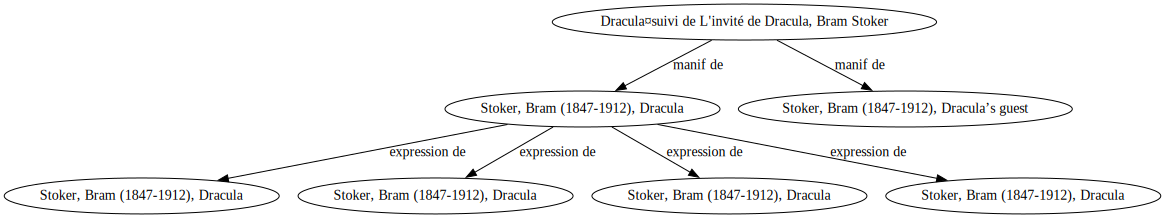

In [31]:
graphe_manif

# Coquilles rencontrées

https://semestriel.framapad.org/p/bugs_unimarclrm

In [32]:
with open("stats_zones.txt", "w", encoding="utf-8") as file:
    for entity in dict_entities:
        for zone in dict_entities[entity].stats_zones:
            line = [entity, dict_entities[entity].type, zone, str(dict_entities[entity].stats_zones[zone])]
            file.write("\t".join(line) + "\n")